In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 11))
y1_inds = Variable(torch.zeros(11).long())
y2_inds = Variable(torch.ones(11).long())
train_y1 = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_y2 = Variable(torch.cos(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
from torch import optim
from gpytorch.kernels import RBFKernel, IndexKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class MultitaskGPModel(gpytorch.GPModel):
    def __init__(self):
        super(MultitaskGPModel,self).__init__(GaussianLikelihood(log_noise_bounds=(-6, 6)))
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-3, 3))
        self.task_covar_module = IndexKernel(n_tasks=2, rank=1)

    def forward(self,x,i):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_i = self.task_covar_module(i)
        covar_xi = covar_x.mul(covar_i)
        return GaussianRandomVariable(mean_x, covar_xi)

model = MultitaskGPModel()

In [5]:
def plot_model_and_predictions(model, plot_train_x=True):
    f, (y1_ax,y2_ax) = plt.subplots(1, 2, figsize=(8, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    y1_inds_test = Variable(torch.zeros(51).long())
    y2_inds_test = Variable(torch.ones(51).long())
    
    observed_pred_y1 = model(test_x,y1_inds_test)
    observed_pred_y2 = model(test_x,y2_inds_test)

    def ax_plot(ax, train_y, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_x:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(y1_ax, train_y1, observed_pred_y1, 'Observed Values (Likelihood)')
    ax_plot(y2_ax, train_y2, observed_pred_y2, 'Observed Values (Likelihood)')
    
    return f

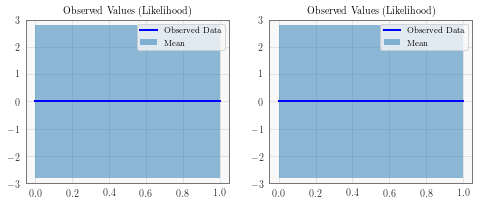

In [6]:
f = plot_model_and_predictions(model, plot_train_x=False)

In [7]:
# Find optimal model hyperparameters
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(50):
    optimizer.zero_grad()
    output = model(torch.cat([train_x, train_x]), torch.cat([y1_inds, y2_inds]))
    loss = -model.marginal_log_likelihood(output, torch.cat([train_y1, train_y2]))
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()
    
# Set back to eval mode
model.eval()
None

Iter 1/50 - Loss: 1.228
Iter 2/50 - Loss: 1.201
Iter 3/50 - Loss: 1.199
Iter 4/50 - Loss: 1.126
Iter 5/50 - Loss: 1.179
Iter 6/50 - Loss: 1.076
Iter 7/50 - Loss: 1.074
Iter 8/50 - Loss: 1.047
Iter 9/50 - Loss: 1.087
Iter 10/50 - Loss: 0.970
Iter 11/50 - Loss: 1.025
Iter 12/50 - Loss: 0.932
Iter 13/50 - Loss: 0.912
Iter 14/50 - Loss: 0.930
Iter 15/50 - Loss: 0.935
Iter 16/50 - Loss: 0.808
Iter 17/50 - Loss: 0.782
Iter 18/50 - Loss: 0.878
Iter 19/50 - Loss: 0.727
Iter 20/50 - Loss: 0.774
Iter 21/50 - Loss: 0.739
Iter 22/50 - Loss: 0.668
Iter 23/50 - Loss: 0.730
Iter 24/50 - Loss: 0.613
Iter 25/50 - Loss: 0.820
Iter 26/50 - Loss: 0.708
Iter 27/50 - Loss: 0.631
Iter 28/50 - Loss: 0.688
Iter 29/50 - Loss: 0.743
Iter 30/50 - Loss: 0.658
Iter 31/50 - Loss: 0.497
Iter 32/50 - Loss: 0.495
Iter 33/50 - Loss: 0.676
Iter 34/50 - Loss: 0.680
Iter 35/50 - Loss: 0.629
Iter 36/50 - Loss: 0.582
Iter 37/50 - Loss: 0.639
Iter 38/50 - Loss: 0.671
Iter 39/50 - Loss: 0.756
Iter 40/50 - Loss: 0.599
Iter 41/5

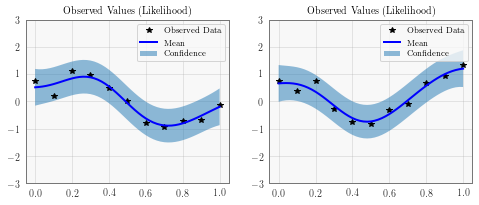

In [8]:
model.condition((torch.cat([train_x, train_x]), torch.cat([y1_inds, y2_inds])), torch.cat([train_y1, train_y2]))
f = plot_model_and_predictions(model)